In [ ]:
from dataclasses import dataclass
import math
import random
import shortuuid
import typing
import pandas as pd
import subprocess
import os
import shutil
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

## Simulation

In [31]:
def get_alpha_beta_from_mean_variance(mu, sigma):
    alpha = ((1-mu)/sigma**2 - 1/mu) * (mu)**2
    beta = alpha * (1/mu - 1)
    if alpha < 0:
        print('mu, sigma:', mu, sigma)
        print('alpha, beta: ', alpha, beta)
    return alpha, beta

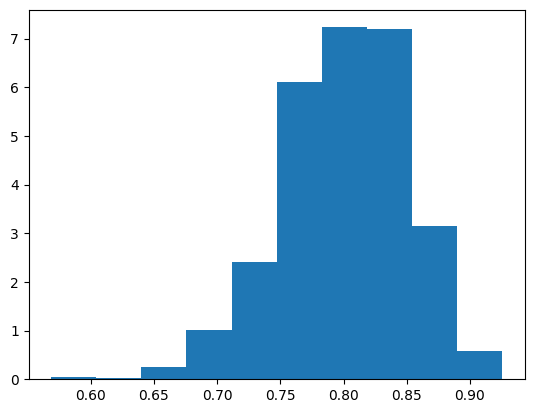

In [32]:
# example usage of function to create beta distribution

mu = 0.8
std = 0.05
alp, bet = get_alpha_beta_from_mean_variance(mu, std)
_ =  plt.hist(np.random.beta(alp, bet, size = 1000), density= True)

In [33]:
@dataclass
class Artist:
    id : str
    avg_characteristicness : float # not strictly bounded, but should sit in [0, 1]
    std_characteristicness : float 
    def create_real_ArtImage(self, subject):
        alpha, beta = get_alpha_beta_from_mean_variance(self.avg_characteristicness, self.std_characteristicness)
        return ArtImage(
            id = f'img~{shortuuid.uuid()}',
            is_ai = False,
            characteristicness = np.random.beta(alpha, beta, size = None), # returns single value
            artist = self,
            creator = self,
            subject = subject
        )
    
@dataclass
class ArtImage:
    id: str
    is_ai: bool # whether the ArtImage is AI or real
    characteristicness: float # between 0 and 1
    artist: Artist
    creator: Artist
    subject: str

In [34]:
def score_diff_to_probability(diff): 
    return 1 / (1 + math.e**(diff))

In [35]:
@dataclass
class Participant:
    id: str
    skill: float # average value of 5 is reasonable (see calibration section below)

    def compare_two_ArtImages(self, ArtImage1 : ArtImage, ArtImage2 : ArtImage):
        diff = ArtImage2.characteristicness - ArtImage1.characteristicness
        prob = score_diff_to_probability(self.skill * diff)
        if random.uniform(0, 1) <= prob:
            return ArtImage1
        else:
            return ArtImage2

In [48]:
@dataclass
class LLM:
    id : str
    ability_to_mimic_style: float # [0,1]
    # this should only rarely be higher than an artist's own characteristicness

    # def create_ai_ArtImage_given_artist(self, artist : Artist) -> ArtImage:
    #     new_avg = self.ability_to_mimic_style * artist.avg_characteristicness
    #     alpha, beta = get_alpha_beta_from_mean_variance(new_avg, artist.std_characteristicness)
    #     return ArtImage(
    #         id = f'img~{shortuuid.uuid()}',
    #         is_ai = True,
    #         characteristicness=np.random.beta(alpha, beta, size = None),
    #         artist = artist,
    #         creator = self
    #     )
    
    def create_ai_ArtImage_matching_image(self, image: ArtImage, std_characteristicness: float) -> ArtImage:
        new_avg = self.ability_to_mimic_style * image.characteristicness
        alpha, beta = get_alpha_beta_from_mean_variance(new_avg, std_characteristicness)
        return ArtImage(
            id = f'img~{shortuuid.uuid()}',
            is_ai = True,
            characteristicness=np.random.beta(alpha, beta, size = None),
            artist = image.artist,
            creator = self,
            subject = image.subject
        )

Specification of model:
$$ logit(P(i > j)) \sim (c_j + A ) - (c_i + A) $$
where $i$ and $j$ are different images. Note that $\sim$ indicates that the LHS is modelled by a linear combination of the RHS variables plus random noise.

And a more complex model:

$$ logit(P(i > j)) \sim (c_j + A_x ) - (c_i + A_y ) $$

where $x$ and $y$ are AI models. 

Incorporating entanglement:

$$ logit(P(i > j)) \sim (c_j + A_x + W_x ) - (c_i + A_y + W_y ) $$

where $W_x$ and $W_y$ are 1 if the subject is anachronistic

probability of one ArtImage being chosen: 

$$P(A > B) := \frac{e^{\lambda \cdot p_A} }{ e^{\lambda \cdot p_A} + e^{\lambda \cdot p_B} }  $$

where $S_x$ is the skill of the participant $x$. If $S_x$ is 

$$ P(A > B) := \frac{1}{1 + e^{\lambda \cdot ( p_B - p_A) }}  $$

## Running overall simulation

In [49]:
import itertools

In [50]:
def generate_data_for_simulation(
        filename,
        N_PARTICIPANTS = 40,
        avg_participant_skill = 1,
        std_participant_skill = 0.05,
        N_ARTISTS = 4, 
        avg_real_artist_characteristicness = 0.7,
        std_real_artist_characteristicness = 0.05,
        N_ARTWORKS_PER_ARTIST = 12, 
        LLM_ABILITIES = [0.95, 0.9, 0.8, 0.5],
        N_TRIALS_PER_LLM_IN_ARTIST_BLOCK = 1,
        num_subjects_per_artist = 1
):
    print('part skill:', avg_participant_skill)
    artists = [Artist(
        id=f'art~{shortuuid.uuid()}',
        avg_characteristicness=avg_real_artist_characteristicness,
        std_characteristicness=std_real_artist_characteristicness
    ) for _ in range(N_ARTISTS) ]

    real_artworks = []
    for artist in artists:
        subjects = itertools.cycle(range(num_subjects_per_artist))
        for _ in range(N_ARTWORKS_PER_ARTIST):
            real_artworks.append(artist.create_real_ArtImage(subject=next(subjects)))

    llms = [ LLM(id = shortuuid.uuid(),ability_to_mimic_style = s) for s in LLM_ABILITIES]

    ai_artworks = []
    for real_artwork in real_artworks:
        for llm in llms:
            ai_artworks.append(llm.create_ai_ArtImage_matching_image(real_artwork, std_real_artist_characteristicness))

    participants = [
        Participant(f'par~{shortuuid.uuid()}', skill = s)
        for s in np.random.normal(loc = avg_participant_skill, scale = std_participant_skill, size=N_PARTICIPANTS)
    ]

    trial_outcomes  = []
    # this can probably be vectorised if it's slow, leave for now
    for participant in participants:
        for artist in artists:
            artist_real_works = itertools.cycle([el for el in real_artworks if el.artist == artist])
            for llm in llms:
                for _ in range(N_TRIALS_PER_LLM_IN_ARTIST_BLOCK):
                    real_artwork = next(artist_real_works)
                    ai_artwork = random.choice([
                        a for a in ai_artworks if a.artist == real_artwork.artist and a.subject == real_artwork.subject and a.creator == llm
                    ])

                    chosen_ArtImage = participant.compare_two_ArtImages(real_artwork, ai_artwork)
                    record = {
                        'participant' : participant.id,
                        'real_artwork' : real_artwork.id,
                        'ai_artwork' : ai_artwork.id,
                        'artist' : real_artwork.artist,
                        'subject' : real_artwork.subject,
                        'llm' : ai_artwork.creator.id,
                        'real_win': int(chosen_ArtImage == real_artwork),
                        'ai_win' : int(chosen_ArtImage != real_artwork)
                    }
                    trial_outcomes.append(record)

    df = pd.DataFrame(trial_outcomes)
    df = df[['real_artwork', 'ai_artwork', 'real_win', 'ai_win']]
    count_table_r = df.groupby(by=['real_artwork', 'ai_artwork']).sum().reset_index()
    count_table_r.to_csv(filename, index=False)

In [ ]:
def run_simulation_n_times(folder_name, N = 100, **simulation_args):
    shutil.rmtree(f'data/{folder_name}', ignore_errors = True)
    os.mkdir(f'data/{folder_name}')
    for i in range(N):
        generate_data_for_simulation(f'data/{folder_name}/{i}.csv', **simulation_args)

    # run R scripts
    for i in range(N):
        subprocess.run(['Rscript', 'model_fit.R', f'data/{folder_name}/{i}.csv', f'data/{folder_name}/results_{i}.csv'])

    # read R scripts
    df = pd.concat([pd.read_csv(f'data/{folder_name}/results_{i}.csv', names=['lower', 'estimate', 'upper', 'p_value'], header=None) for i in range(N)])
    df.to_csv(f'data/{folder_name}/sim_results.csv')
    df.estimate.hist()
    plt.title('Distribution of AI coefficient estimate')
    plt.xlabel('$\\beta$ coefficient value for `is_ai` indicator variable')
    plt.savefig(f'data/{folder_name}/estimate_hist.png')
    plt.show()
    df.p_value.hist()
    prop_significant = (df.p_value < 0.05).mean()
    plt.title(f'Distribution of p value ({prop_significant:.0%} of simulations stat. sig.)', wrap=True)
    plt.xlabel('p value')
    plt.savefig(f'data/{folder_name}/p_value_hist.png')

    # chi-squared approach: TODO


    return 

part skill: 5


Warning message:
Ability modelled by predictors but no random effects 
Waiting for profiling to be done...


part skill: 5


Warning message:
Ability modelled by predictors but no random effects 
Waiting for profiling to be done...


part skill: 5


Warning message:
Ability modelled by predictors but no random effects 
Waiting for profiling to be done...


part skill: 5


Warning message:
Ability modelled by predictors but no random effects 
Waiting for profiling to be done...


part skill: 5


Warning message:
Ability modelled by predictors but no random effects 
Waiting for profiling to be done...


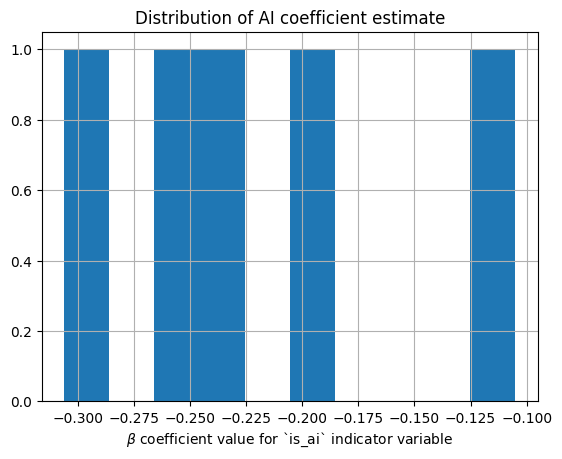

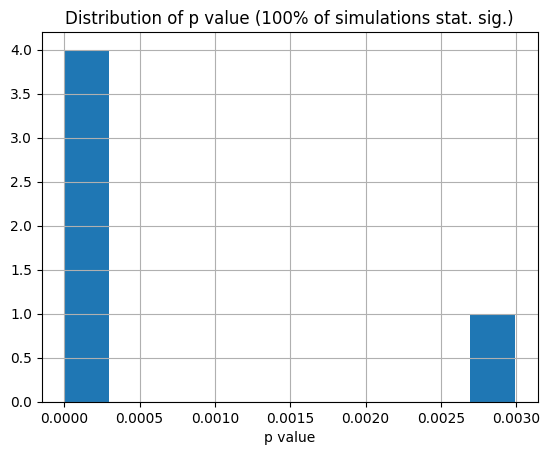

In [58]:
test_df = run_simulation_n_times('test', N = 5, LLM_ABILITIES = [0.95,0.95,0.95,0.95], avg_participant_skill=5, N_PARTICIPANTS=200)

# Calibration

In [ ]:
### How do the following scenarios: (99/1, 90 / 10, 75/25, 55/45) translate to skill / characteristicness combinations?

### Aim: function mapping difference in scores to probabilities

0.99 4.6000000000000005
0.9 2.2
0.75 1.1
0.55 0.2


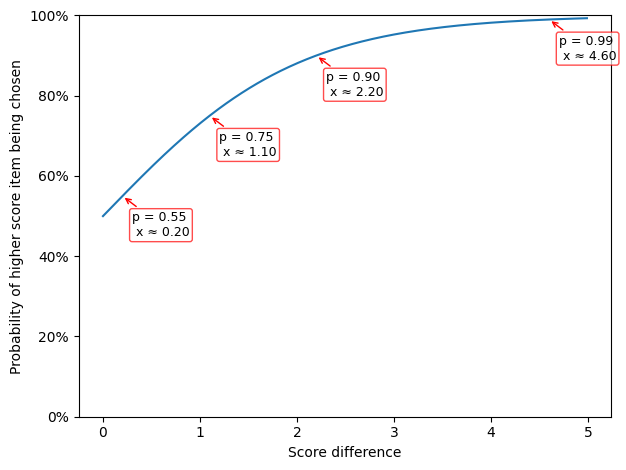

In [ ]:
x = np.arange(0, 5, 0.01)
y = 1 - score_diff_to_probability(x) 

probs_of_interest = [0.99, 0.9, 0.75, 0.55]
for p in probs_of_interest:
    idx = (np.abs(y - p)).argmin()
    print(p, x[idx])
# if the diff is positive, it means that B has better score than A, (so p(A>B) < 0.5) . 
# So we take 1 - {this function} for the purposes of this calibration, which gives p(B>A)
plt.plot(x, y)
for p in probs_of_interest:
    idx = (np.abs(y - p)).argmin()
    x_val = x[idx]

    # Vertical & horizontal guides
    # plt.axvline(x_val, color='red', linestyle='--', lw=1, alpha=0.7)
    # plt.axhline(p, color='gray', linestyle=':', lw=1, alpha=0.4)

    # Annotate with arrow
    plt.annotate(
        f'p = {p:.2f}\n x ≈ {x_val:.2f}',
        xy=(x_val, p),
        xytext=(x_val + 0.1, p - 0.1),
        textcoords='data',
        arrowprops=dict(arrowstyle='->', color='red', lw=1),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='red', alpha=0.7)
    )
plt.ylim((0,1))
plt.xlabel('Score difference')
plt.ylabel('Probability of higher score item being chosen')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
plt.tight_layout()

In [ ]:
comparisons = pd.Series([
    (0, 1),
    (0.5, 1),
    (0.75, 1),
    (0.9, 1),
    (0.95, 1)
])
skill = 5
comparisons.map(lambda el: score_diff_to_probability(skill * (el[0] - el[1])))

0    0.993307
1    0.924142
2    0.777300
3    0.622459
4    0.562177
dtype: float64

# Further notes

To do:
- no repeats within trials 
- sampling without replacement 
- use same trial block format as in experimental design (done)
- think about what characteristicness per artist is meant to represent (done)
- how to calibrate participant baseline skill for simulations (roughly done, see calibration)

## What simulations do we want to run?

### Sense checks:
- Increasing the # of participants should increase power
- Increasing the skill of participants should increase power
- Reducing avg. characteristicness of artists should increase power
- Reducing the mimicing ability of LLMs should reduce power
- Maintaining average LLM ability but increasing spread should decrease power

### Calibration:
- Need to calibrate how skill influences probability. Maybe fix AI characteristicness at 0.6 and human at 0.7 (so it's a fixed 0.1 diff), then vary

# Other methods:
- Bradley-Terry model w/ regression: done
- Simple method: proportion of wins to AI, run a chi squared test for independence

### Specification of Bradley-Terry model:

$$P(A > B) = \frac{1}{1 + e^{\lambda_B - \lambda_A}},$$
where
$$\lambda_A = \beta_A +  \beta_0 \cdot is\_ai_A + \beta_1 \cdot LLM_1 + \cdots + \beta_m \cdot LLM_{m}  + \beta_{m+1} \cdot is\_anachronistic + \epsilon, \\ \epsilon \sim N(0, \theta)$$
